# MiniGPT: A Modular LLM Training Framework

This notebook presents a clean, modular framework for training transformer-based (decoder) language models from scratch.

## Framework Components:
1. **Model Architecture**: Decoder-only transformer implementation
2. **Data Pipeline**: Flexible data loading and preprocessing
3. **Training System**: Configurable training loop with callbacks
4. **Logging Infrastructure**: Detailed metrics and checkpoint management

## Framework Architecture

The framework follows this component structure:

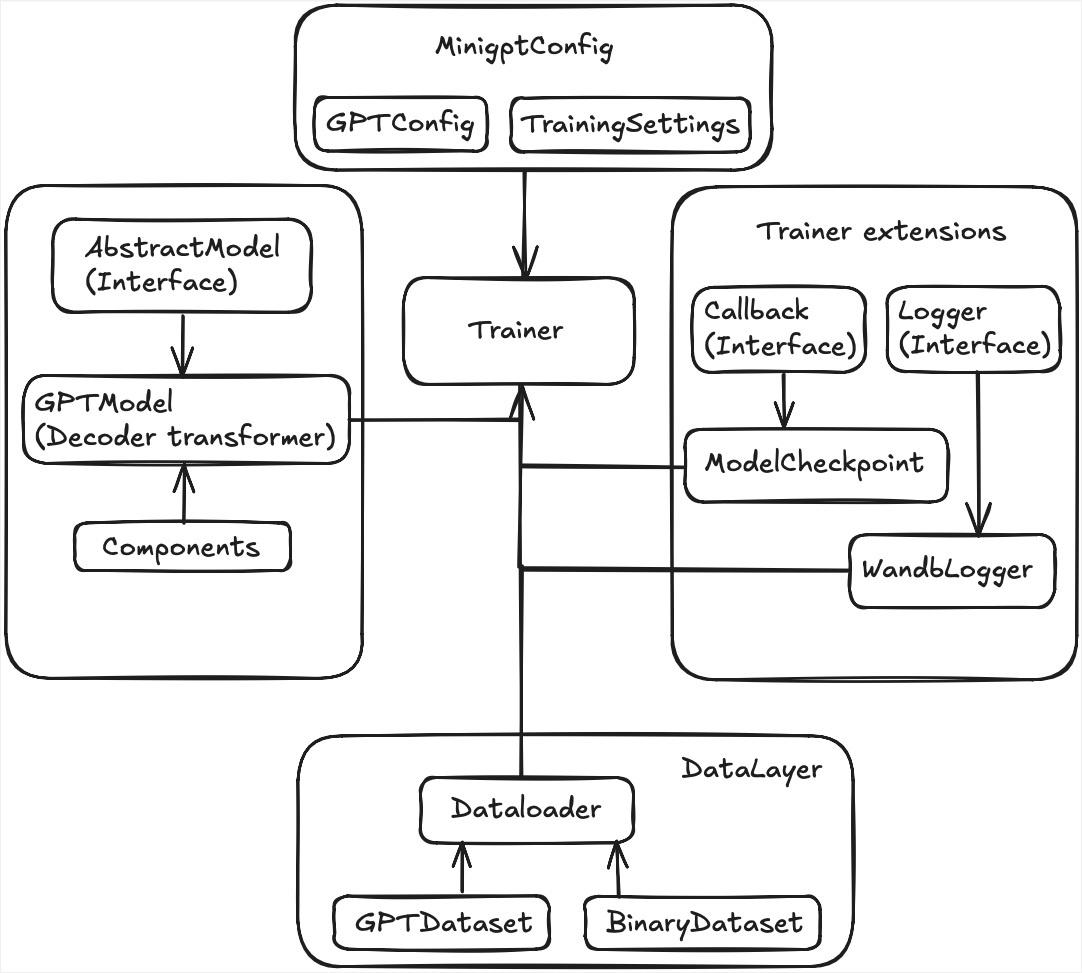

In [27]:
from IPython.display import Image, display

display(Image("../assets/architecture.png", width=700))

### Directory Structure:
```python
src/
└── minigpt
    ├── callbacks         # Training event hooks
    ├── config            # Configuration definitions
    ├── data              # Data loading and processing
    ├── loggers           # Training metrics logging
    ├── model             # Model definitions
    ├── tests             # Component unit tests
    ├── trainer.py        # Main training loop
    └── utils             # Utility functions

# Processing the dataset



In [28]:
from minigpt.data.utils import prepare_dataset

# Process the dataset
data_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
result = prepare_dataset(data_url, "data/")

# Print summary
print("Tiny Shakespeare dataset processed.")
print(f"train.bin has {result['train_tokens']:,} tokens")
print(f"val.bin has {result['val_tokens']:,} tokens")

Using existing file: data/input.txt
Tiny Shakespeare dataset processed.
train.bin has 301,966 tokens
val.bin has 36,059 tokens


In [29]:
# Import configuration components
from minigpt.config.config import GPTConfig, TrainingSettings, MinigptConfig

# Create a model configuration
model_config = GPTConfig(
    vocab_size=50257,
    context_length=256,
    emb_dim=768,
    n_heads=12,
    n_layers=12,
    dropout=0.1,
)

# Display the configuration
print("Model configuration:")
for key, value in model_config.__dict__.items():
    if not key.startswith("_"):
        print(f"  {key}: {value}")

# Create training settings
training_config = TrainingSettings(
    learning_rate=5e-4,
    num_epochs=10,
    batch_size=8,
    weight_decay=0.1,
    eval_freq=20,
    start_context="Once upon a time",
    wandb_project="minigpt-demo",
    data_dir="data",
)

# Combined configuration
config = MinigptConfig(model=model_config, training=training_config)

Model configuration:
  vocab_size: 50257
  context_length: 256
  emb_dim: 768
  n_heads: 12
  n_layers: 12
  dropout: 0.1
  qkv_bias: False


In [ ]:
# Import model components
from minigpt.model.transformer import GPTModel

model = GPTModel(model_config)
print("\nModel structure:")
print(f"  Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


Model structure:
  Number of parameters: 123,813,120


### Transformer Architecture

The GPTModel implements a standard decoder-only transformer with:

1. **Embedding Layers**:
   - Token embeddings for vocabulary items
   - Positional embeddings to capture sequence order

2. **Transformer Blocks**:
   - Multi-head self-attention mechanism with causal masking
   - Feed-forward neural networks with GELU activation
   - Layer normalization and residual connections

3. **Output Head**:
   - Linear projection back to vocabulary size for next-token prediction

Key architectural choices include:
- Optional Flash Attention support for faster training
- Layer normalization before attention and feed-forward (Pre-LN arrangement)
- Configurable number of layers, heads, and embedding dimensions

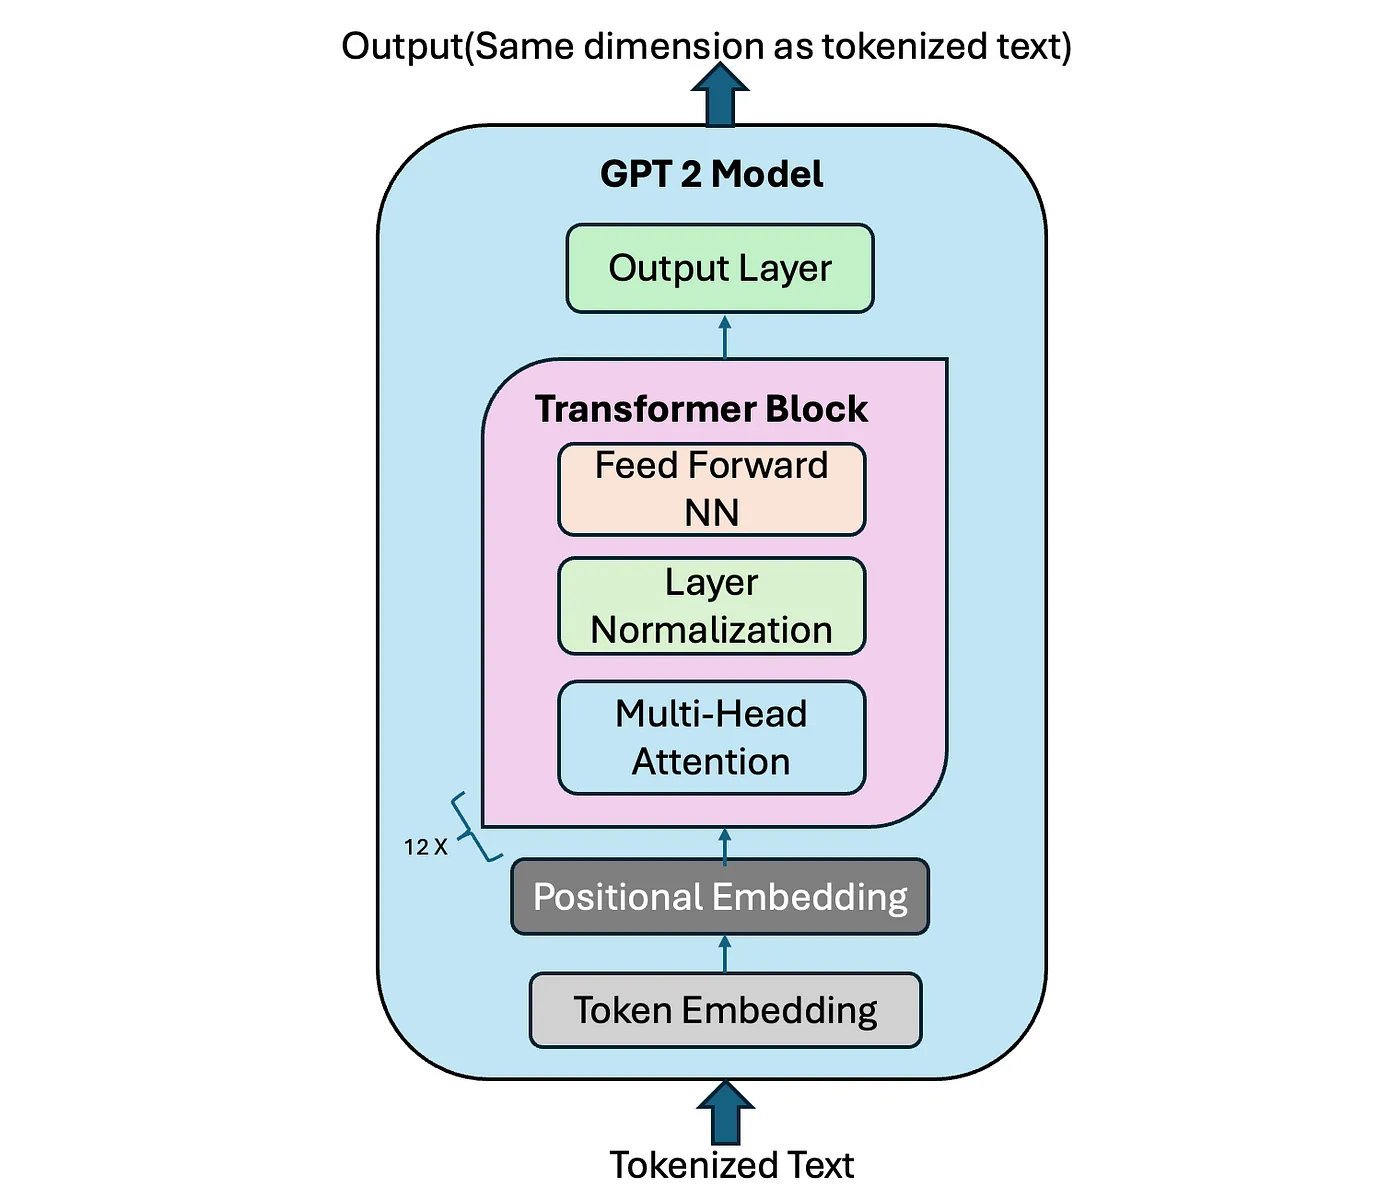

In [31]:
from IPython.display import Image, display

display(Image("../assets/gpt2.webp", width=600))
# Source: https://medium.com/@vipul.koti333/from-theory-to-code-step-by-step-implementation-and-code-breakdown-of-gpt-2-model-7bde8d5cecda

In [32]:
# Import data components
from minigpt.data.dataloader import GPTDataset
import tiktoken
import torch

# Create a small example dataset
tokenizer = tiktoken.get_encoding("gpt2")
sample_text = (
    "This is a small example text for demonstrating the data processing pipeline."
)

# Create a dataset
max_length = 8
dataset = GPTDataset(sample_text, tokenizer, max_length, stride=1)

# Display a few examples
print(f"Dataset contains {len(dataset)} examples")
for i in range(min(3, len(dataset))):
    inputs, targets = dataset[i]
    print(f"\nExample {i + 1}:")
    print(f"  Input tokens:  {inputs.tolist()}")
    print(f"  Input text:    {tokenizer.decode(inputs.tolist())}")
    print(f"  Target tokens: {targets.tolist()}")
    print(f"  Target text:   {tokenizer.decode(targets.tolist())}")

# Create a dataloader
batch_size = 2
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
batch = next(iter(dataloader))
print(f"\nBatch shape: inputs {batch[0].shape}, targets {batch[1].shape}")

Dataset contains 5 examples

Example 1:
  Input tokens:  [1212, 318, 257, 1402, 1672, 2420, 329, 21135]
  Input text:    This is a small example text for demonstrating
  Target tokens: [318, 257, 1402, 1672, 2420, 329, 21135, 262]
  Target text:    is a small example text for demonstrating the

Example 2:
  Input tokens:  [318, 257, 1402, 1672, 2420, 329, 21135, 262]
  Input text:     is a small example text for demonstrating the
  Target tokens: [257, 1402, 1672, 2420, 329, 21135, 262, 1366]
  Target text:    a small example text for demonstrating the data

Example 3:
  Input tokens:  [257, 1402, 1672, 2420, 329, 21135, 262, 1366]
  Input text:     a small example text for demonstrating the data
  Target tokens: [1402, 1672, 2420, 329, 21135, 262, 1366, 7587]
  Target text:    small example text for demonstrating the data processing

Batch shape: inputs torch.Size([2, 8]), targets torch.Size([2, 8])


### Data Pipeline Features

The framework supports two primary data loading approaches:

1. **Text-based loading** (GPTDataset):
   - Processes raw text with a tokenizer
   - Creates sliding window examples with configurable stride
   - Suitable for smaller datasets and quick experiments

2. **Binary data loading** (BinaryDataset):
   - Memory-mapped file access for efficient handling of large datasets
   - Reduced memory footprint for training on big corpora
   - Compatible with preprocessing scripts that convert text to binary format

Both approaches implement the next-token prediction task by shifting the target sequence by one position.

In [33]:
# Import trainer components
from minigpt.callbacks import Callback, ModelCheckpoint

# Show the callback system
print("Available callback hooks:")
for method_name in dir(Callback):
    if not method_name.startswith("_") and method_name != "on_fit_begin":
        print(f"  {method_name}")


# Example custom callback
class TrainingProgressCallback(Callback):
    def on_epoch_start(self, trainer, epoch):
        print(f"Starting epoch {epoch + 1}/{trainer.config.training.num_epochs}")

    def on_validation_end(self, trainer, train_loss, val_loss):
        print(f"Validation - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")


# Example of checkpoint callback configuration
checkpoint_callback = ModelCheckpoint(
    dirpath="./checkpoints",
    filename="minigpt_{epoch}",
    save_freq="epoch",
    every_n_epochs=1,
    monitor="val_loss",
    mode="min",
)

# Show trainer initialization (not executing for demo)
print("\nTrainer initialization example:")
print("""
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    config=config,
    tokenizer=tokenizer,
    logger=logger,
    callbacks=[checkpoint_callback, TrainingProgressCallback()]
)
""")

Available callback hooks:
  on_epoch_begin
  on_epoch_end
  on_evaluate
  on_fit_end
  on_step_begin
  on_step_end

Trainer initialization example:

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    config=config,
    tokenizer=tokenizer,
    logger=logger,
    callbacks=[checkpoint_callback, TrainingProgressCallback()]
)



### Training System Design

The Trainer class orchestrates the entire training process:

1. **Main Training Loop**:
   - Epoch and batch iteration
   - Forward and backward passes
   - Optimization steps

2. **Validation & Evaluation**:
   - Regular evaluation on validation data
   - Metrics computation and logging
   - Optional text generation for qualitative assessment

3. **Callback System**:
   - Event hooks at various training stages
   - Extensible interface for custom behaviors
   - Built-in callbacks for checkpoint management

The design allows for:
- Flexible training configurations
- Easy monitoring and intervention
- Controlled experiment reproducibility

In [34]:
# Import logging components
from minigpt.loggers.abstract_logger import Logger
# from minigpt.loggers import WandbLogger

# Show logger interface
print("Logger interface requires implementing:")
for method_name in dir(Logger):
    if not method_name.startswith("_") and callable(getattr(Logger, method_name)):
        print(f"  {method_name}()")


# Example custom logger
class ConsoleLogger(Logger):
    def __init__(self, log_freq=10):
        self.log_freq = log_freq
        self.step_counter = 0

    def log_metrics(self, metrics, step=None):
        self.step_counter += 1
        if self.step_counter % self.log_freq == 0:
            print(f"Step {step}: {metrics}")

    def log_hyperparams(self, params):
        print(f"Hyperparameters: {params}")

    def save(self):
        pass

    def finalize(self):
        print("Logging complete")


# Show WandB logger example
print("\nWandB logger initialization:")
print("""
logger = WandbLogger(
    project="minigpt-training", 
    name="experiment-1",
    log_model=True
)
""")

Logger interface requires implementing:
  finalize()
  log_hyperparams()
  log_metrics()
  save()

WandB logger initialization:

logger = WandbLogger(
    project="minigpt-training", 
    name="experiment-1",
    log_model=True
)




### Logging & Monitoring

The framework includes a comprehensive logging system that:

1. **Tracks Performance Metrics**:
   - Loss and perplexity during training
   - Validation metrics at configurable intervals
   - Token throughput and other efficiency metrics

2. **Integrates with Weights & Biases**:
   - Real-time visualization of training progress
   - Hyperparameter tracking
   - Optional model checkpointing

3. **Supports Custom Loggers**:
   - Abstract logger interface for extension
   - Consistent API across different logging backends
   - Flexible metric recording

## Extensibility & Future Work

### Framework Extension Points

The MiniGPT framework is designed for easy extension:

1. **Model Architecture**:
   - Implement `AbstractModel` for different architectures
   - Add new attention mechanisms or positional encodings
   - Support different token generation strategies

2. **Data Processing**:
   - Add dataset implementations for specialized data sources
   - Implement new preprocessing techniques
   - Support different tokenization approaches

3. **Training Capabilities**:
   - Create custom callbacks for specific monitoring needs
   - Implement different logging backends
   - Add specialized optimization strategies

### Future Improvements

Potential enhancements to the framework:

1. **Scaling Capabilities**:
   - Distributed training across multiple GPUs/nodes
   - Mixed precision training for faster computation
   - Gradient accumulation for larger batch sizes

2. **Advanced Techniques**:
   - Parameter-efficient fine-tuning (LoRA, Adapters)
   - Quantization for inference efficiency
   - Curriculum learning strategies

3. **Production Readiness**:
   - Model export to deployment formats
   - Integration with serving frameworks
   - Performance benchmarking tools

# Training runs 

[Wandb: Redpajama dataset, 100M samples, 124M params transformer](https://wandb.ai/quantcomp/minigpt-training/runs/rzgt7510/workspace?nw=nwuserquantdavidos)

Perplexity: around 250, SOTA LLMs can reach values between 10-60. 

